# ДЗ №6

ВНИМАНИЕ!!! Выполнение блокнота может занять много времени. Программа **отправляет запросы стороннему web-сайту.** Подробности см. ниже.

В рамках этого ДЗ мы обучим модель для предсказания, является ли отзыв на видеоигру положительным или отрицательным.

Данные соберем с сайта https://stopgame.ru/games/reviews

In [4]:
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")
import requests
import nltk
import pymorphy2
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from fake_useragent import UserAgent

random.seed(123)
np.random.seed(123)

## Сбор данных

Собираем только тексты отзывов и рейтинг видеоигры. **Не будем собирать никаких сведений об авторах.**

Целевая переменная - является ли отзыв положительным (значение 1) или отрицательным (значение 0). На сайте рейтинг видеоигры измеряется в "звездочках" от нуля до пяти (возможно значение "пол-звездочки"). 

Будем считать все отзывы с оценкой более или равной 4 положительными, а все отзывы менее 4 - отрицательными.

### Объявим функции для парсинга

In [6]:
from bs4 import BeautifulSoup
import time
import re

def parse_web_site(n_pages = 500, delay_sec = 2.0):
    '''
    Возвращает список 'текст отзыва' + 'рейтинг от 0 до 5 (float)'. 
    '''
    all_reviews = []
    request_headers = {'User-Agent': UserAgent().chrome}
    for i in range(1, n_pages):
        # ожидаем, что бы не перегружать сайт запросами
        time.sleep(delay_sec)

        page_url = f'https://stopgame.ru/games/reviews/date/p{i}'
        response = requests.get(page_url, headers=request_headers)
        if response.ok:
            reviews = parse_page(response.content)
            all_reviews.extend(reviews)
        else:
            print(f'Невозможно открыть страницу! HTTP статус: {response.status_code}')
            break
    return all_reviews

def parse_page(html):
    soup = BeautifulSoup(html, 'html.parser')
    articles = soup.find_all('article')
    reviews = []
    for article in articles:
        review_text, rating = parse_article(article)
        reviews.append((review_text, rating))
    return reviews

def parse_article(articleTag):
    review_text = get_review_text(articleTag)
    rating = get_rating(articleTag)
    return review_text, rating

def get_review_text(articleTag):
    text = articleTag.find('section').text
    # оставляем только текст на русском языке, тем самым отбрасывая все HTML тэги
    regex = re.compile(r'[А-Яа-яЁ]+')
    return " ".join(regex.findall(text)).lower()

def get_rating(articleTag):
    div = articleTag.find('div', attrs={'class':'_stars--filled_l03f1_1'})
    stars = div.find_all('svg')
    rating = float(len(stars))
    if rating != 0:
        last_star_attrs = stars[-1].attrs
        # рейтинг может включать в себя "пол-звездочки"
        if (('class' in last_star_attrs) and ('_half-star_l03f1_60' in last_star_attrs['class'])):
            return rating - 0.5
    return rating

### Парсинг

**ВНИМАНИЕ!!! Этот блок кода отправляет запросы к стороннему web-сайту!!!** Что бы не оказывать нагрузки на сайт, между запросами выдерживается пауза в 2 секунды.

Код выполняется **более 16 минут.**

In [7]:
reviews_with_rating = parse_web_site(n_pages=500, delay_sec=2.0)

In [9]:
# раскомментируйте этот блок кода, если хотите сохранить результат парсинга в файл
'''
import codecs

with codecs.open("./data/reviews.csv", "w", "utf-8") as file:
    for review in reviews_with_rating:
        file.write(review[0] + ',' + str(review[1]) + '\n')
'''

In [ ]:
# чтение результатов парсинга из файла
'''
import pandas as pd

data_texts = []
data_y = []

reviews_df = pd.read_csv('./data/reviews.csv', header=None)
for row in reviews_df.itertuples(index=False):
    try:
        if type(row[0]) is str and row[0]:
            data_texts.append(row[0])
            data_y.append(row[1])
    except:
        print(row)

print(len(data_texts), len(data_y))
'''

In [13]:
data_texts = []
data_y = []

for row in reviews_with_rating:
    review = row[0]
    rating = row[1]
    try:
        if type(review) is str and review:
            data_texts.append(review)

            # Рейтинг 4+ соответствует положительному отзыву.
            # Значения ниже 4 - отризательному.
            y = 1 if rating >= 4.0 else 0
            data_y.append(y)
    except:
        print(row)

# выводим на экран случайный отзыв
print(data_texts[200])
print(data_y[200])

это сложно быстро и весело точно советую к ознакомлению
1


## Обработка

Проведем лемманизацию датасета.

In [15]:
morph = pymorphy2.MorphAnalyzer()
data_lemmatized = []

for i in range(len(data_texts)):
    text = data_texts[i]
    data_texts[i] = ' '.join([morph.parse(x)[0].normal_form for x in text.split(' ')])

    if i % 100 == 0:
        print(f'Обработано {i + 1} отзывов.')
print(f'Завершено.')

Обработано 1 отзывов.
Обработано 101 отзывов.
Обработано 201 отзывов.
Обработано 301 отзывов.
Обработано 401 отзывов.
Обработано 501 отзывов.
Обработано 601 отзывов.
Обработано 701 отзывов.
Обработано 801 отзывов.
Обработано 901 отзывов.
Обработано 1001 отзывов.
Обработано 1101 отзывов.
Обработано 1201 отзывов.
Обработано 1301 отзывов.
Обработано 1401 отзывов.
Обработано 1501 отзывов.
Обработано 1601 отзывов.
Обработано 1701 отзывов.
Обработано 1801 отзывов.
Обработано 1901 отзывов.
Обработано 2001 отзывов.
Обработано 2101 отзывов.
Обработано 2201 отзывов.
Обработано 2301 отзывов.
Обработано 2401 отзывов.
Обработано 2501 отзывов.
Обработано 2601 отзывов.
Обработано 2701 отзывов.
Обработано 2801 отзывов.
Обработано 2901 отзывов.
Обработано 3001 отзывов.
Обработано 3101 отзывов.
Обработано 3201 отзывов.
Обработано 3301 отзывов.
Обработано 3401 отзывов.
Обработано 3501 отзывов.
Обработано 3601 отзывов.
Обработано 3701 отзывов.
Обработано 3801 отзывов.
Обработано 3901 отзывов.
Обработано 4

In [16]:
print(data_texts[200])

это сложно быстро и весело точно советовать к ознакомление


Разделим датасет на тренировочный и тестовый.

In [17]:
train_texts, test_texts, train_y, test_y = train_test_split(data_texts, data_y, test_size=0.2, random_state=123, stratify = data_y)

print(f'Общий размер датасета: {len(data_texts)}')
print(f'Размер тренировочного датасета: {len(train_texts)}')
print(f'Размер тестового датасета: {len(test_texts)}')

Общий размер датасета: 9969
Размер тренировочного датасета: 7975
Размер тестового датасета: 1994


Проведем TF-IDF векторизацию, удалим стоп слова, а также наиболее и наименее употребляемые слова.

In [151]:
nltk.download('stopwords')
# Стоп-слова, стандартные для русского языка. Хорошо бы добавить слова, специфические для данной предметной области, однако это не так просто. См. "Выводы".
stop_words = nltk.corpus.stopwords.words('russian')

vectorizer = TfidfVectorizer(
                                max_features = 20000,
                                norm=None,
                                ngram_range=(1, 2),
                                stop_words=stop_words,
                                min_df=100,
                                max_df=6000
                             )
train_X = vectorizer.fit_transform(train_texts)
test_X = vectorizer.transform(test_texts)

feature_names = vectorizer.get_feature_names_out()
print('Общее число признаков: ', len(feature_names))
print('100 признаков:\n', feature_names[:100])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vasilij\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Общее число признаков:  1645
100 признаков:
 ['абсолютно' 'автомат' 'автор' 'ад' 'аж' 'акт' 'активность' 'активный'
 'аналог' 'английский' 'анимация' 'аниме' 'арена' 'аркадный' 'арсенал'
 'арт' 'артефакт' 'аспект' 'атака' 'атаковать' 'атмосфера' 'атмосферный'
 'аудитория' 'баг' 'база' 'базовый' 'баланс' 'балл' 'банально' 'банальный'
 'бег' 'бегать' 'бежать' 'безумный' 'белый' 'бесить' 'бесконечный'
 'бесплатный' 'бесполезный' 'битва' 'бить' 'благо' 'благодаря' 'ближний'
 'ближний бой' 'близкий' 'близкий конец' 'блин' 'блок' 'бо' 'бо вка' 'бог'
 'богатый' 'бодрый' 'боевик' 'боевка' 'боевой' 'боевой система' 'бой'
 'боль' 'больно' 'больший' 'больший часть' 'большинство' 'большой'
 'большой весь' 'большой количество' 'бомба' 'бонус' 'борьба' 'босс' 'бот'
 'бояться' 'брат' 'брать' 'бросать' 'бросить' 'будущее' 'буквально'
 'бывать' 'быстро' 'быстрый' 'бюджет' 'важно' 'важный' 'вариант'
 'вариативность' 'ваш' 'ведьмак' 'везде' 'великий' 'великолепно'
 'великолепный' 'верить' 'вернуть' 'верн

## Моделирование

Исследуем баланс классов.

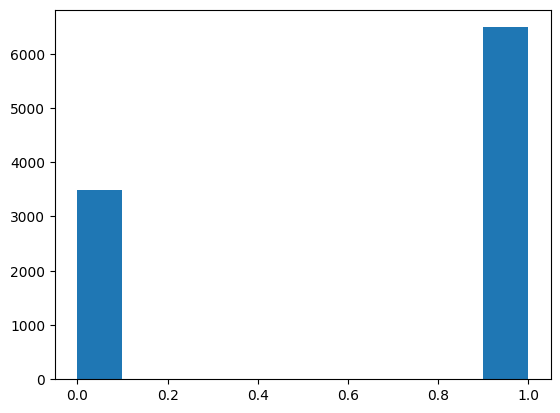

In [133]:
plt.hist(data_y)
plt.show()

Обучим модель.

In [152]:
regressor = LogisticRegression(C=0.01, random_state=123)
regressor.fit(train_X, train_y)
pred = regressor.predict(test_X)

print(f'Accuracy: {accuracy_score(test_y, pred)}')
print(f'F1: {f1_score(test_y, pred, average = "macro")}')
print(f'ROC-AUC: {roc_auc_score(test_y, pred)}')

Accuracy: 0.7362086258776329
F1: 0.6902603853509468
ROC-AUC: 0.6820993393903972


Возьмем 50 признаков, которые вносят наибольший вклад в предсказание модели.

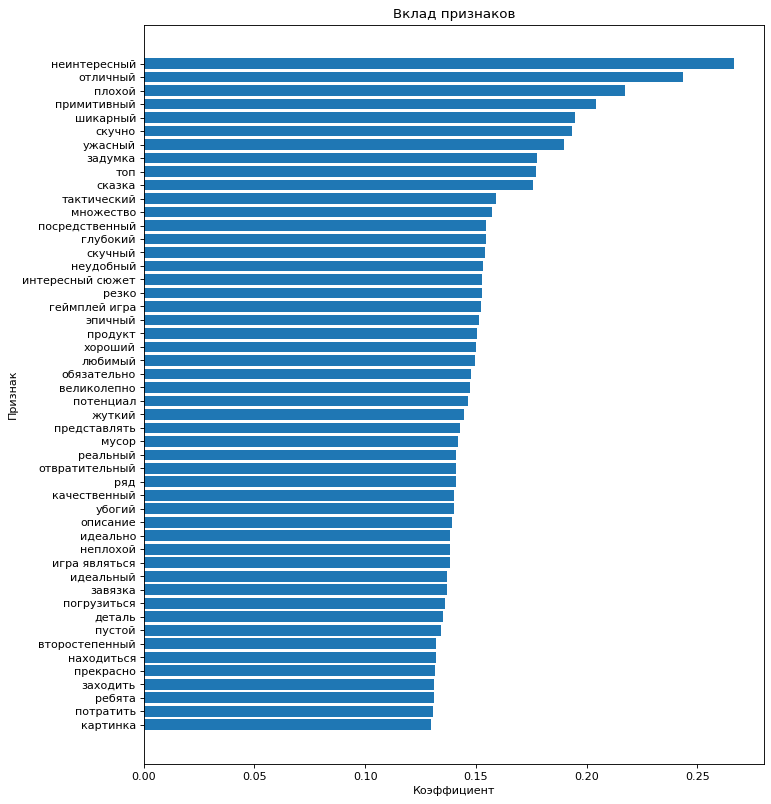

In [153]:
def visualize_coefficients(_regressor, _feature_names, _greatest_impact = True):
    coef = abs(_regressor.coef_[0])

    coef_features = list(zip(coef, _feature_names))

    # отсортируем признаки по значению коэффициента
    coef_features.sort(key=lambda x: x[0], reverse=_greatest_impact)
    # возьмем топ-50 признаков
    coef_features = coef_features[:50]
    # отсортируем признаки по значению коэффициента от меньшего к большему. Таким образом наиболее значимый признак будет отображатся в верхней части диаграммы
    coef_features.sort(key=lambda x: x[0], reverse=False)

    coef, feature_names = zip(*coef_features)
    
    plt.figure(figsize=(10, 12), dpi=80)

    # визуализируем топ-50
    plt.barh(feature_names, coef)
    plt.ylabel("Признак")
    plt.xlabel("Коэффициент") 
    plt.title("Вклад признаков")
    plt.show()

visualize_coefficients(regressor, feature_names, _greatest_impact=True)

Теперь попробуем визуализировать топ-50 признаков, которые вносят наименьший вклад в предсказание.

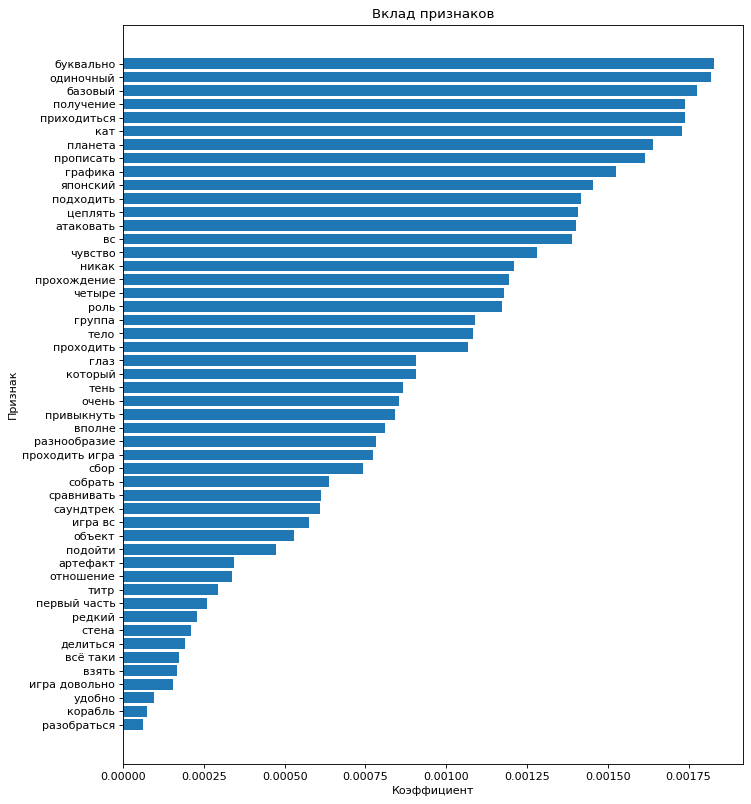

In [154]:
visualize_coefficients(regressor, feature_names, _greatest_impact=False)

## Выводы

Серьезная проблема - слова, которые специфичны для одной игры, но при этом часто встречаются в отзывах. К примеру, вышла новая игра. Она приобрела популярность и на нее было написано множество отзывов. Отзывы содержат в себе специфическую для игры терминологию (например, слово "хогвардс"). Если превалируют отзывы одного типа (допустим, игра понравилась большенству игроков), то такие слова могут приводить к завышенной оценке качества. Например, если уменьшить min_df, то метрика F1 будет равнятся 0.73.
Если взглянуть на топ-50 наименее значимых признаков, то в конце списка можно видеть слово "корабль". Можно предположить, что вышла какая-то игра (или хуже того, несколько игр) посвещенная определенной теме (мореплавание или космические полеты). В результате мы получили бесполезный признак, который не так-то просто отсеять при помощи стоп-слов (не перечислять же всю возможную игровую терминологию).

Возможное решение проблемы:
- Составить список наиболее употребляемых слов и выделить оттуда специфичную для игр терминологию, которую затем добавить в список стоп-слов.
- Если датасет содержит черезчур много отзывов, посвященных определенной игре, то часть отзывов можно исключить из тренировочного датасета (перебросить их в тестовый).
- Увеличивать min_df (даже ценой уменьшения качества).